Before we can use the camera images (test images and videos) we have to perform the camera calibration. The next cell uses the provided calibration images to compute a set of parameters which will be used later to compensate for optical distortion.

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)               # Read to RGB pixel format
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

The code cell above creates the two lists `objpoints` and `imgpoints` of matching 3D to 2D (pixel) coordinate pairs. This data is the input of the `calibrateCamera` function, which calculates the parameter set we need to undistort the images. Note that 3D coordinates are in an arbitrary set of axes, and in our case, the axes are local to the chessboard pattern, giving integer coordinates (0,0,0) to (8,5,0). All the points are in the Z=0 plane, which is the plane of the chessboard.

The code cell below computes and saves the calibration parameters `mtx` and `dist`, applies them to a test image which is saved and displayed, and cleans up the workspace.

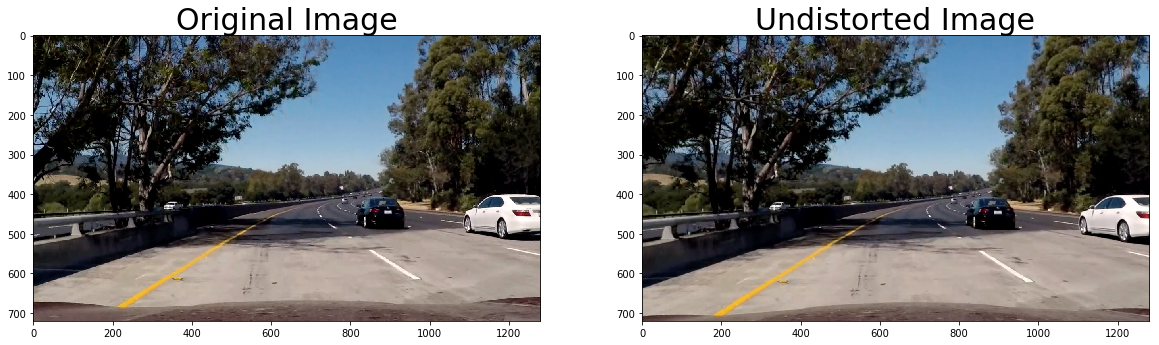

In [10]:
import pickle

# Test undistortion on an image
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
# Calibration is also relative to a given image size
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
mpimg.imsave('output_images/test5_undistorted.png',dst,format='png')

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

%matplotlib inline

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Clean up workspace: keep only img_size, mtx and dist (and objpoints and imgpoints too)
del ax1, ax2, f, dst, img, dist_pickle, ret, rvecs, tvecs

The function below selects pixels based on their color in a user-chosen colorspace. What is actually does, is just threshold a single channel image.

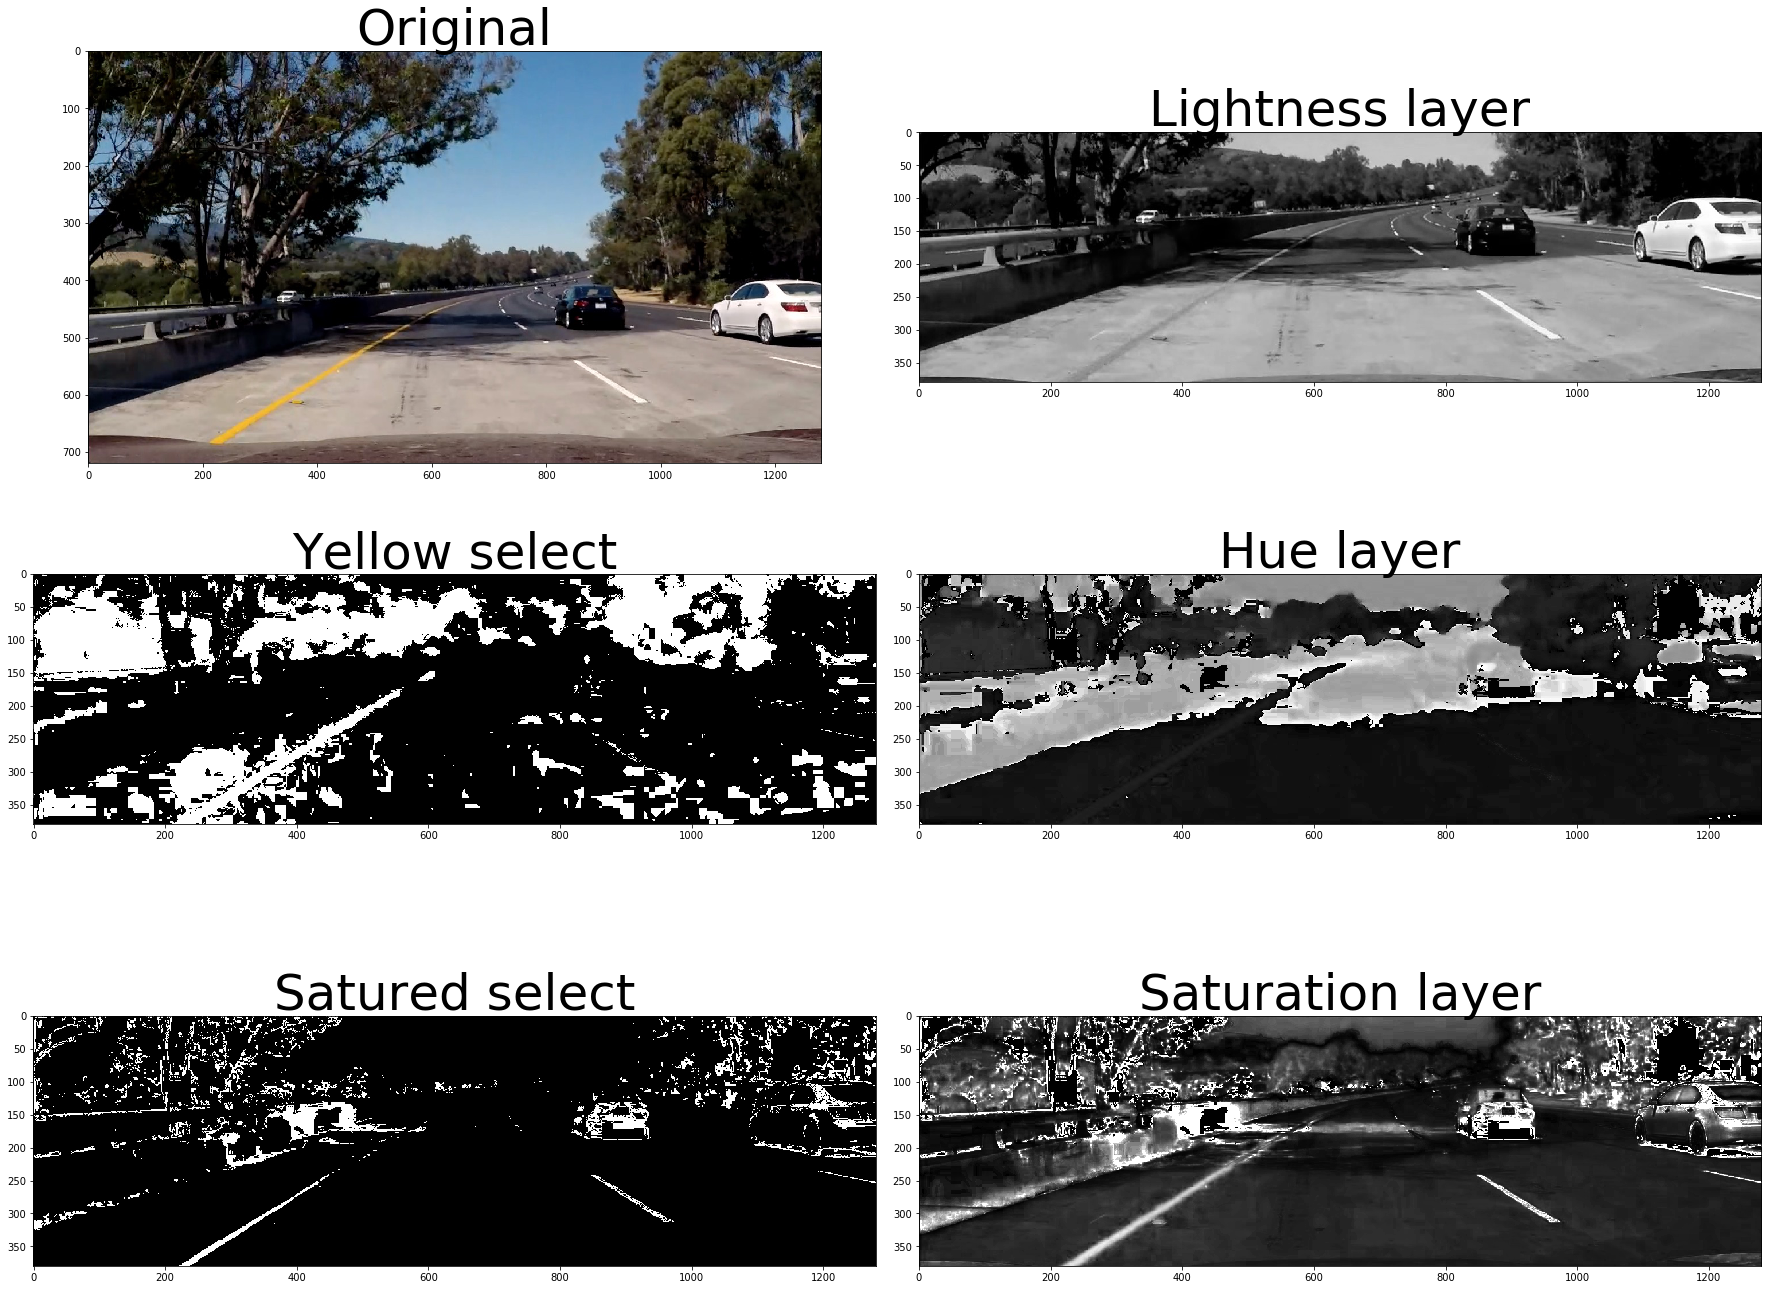

In [99]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def color_thresh(image, thresholds=(0,255)):
    assert len(image.shape) == 2, 'gradient_thresh: image input must be 2D numpy image'
    assert image.dtype == np.uint8, 'color_thresh: image dtype must be numpy.uint8'
    binary = np.zeros_like(image, dtype=np.uint8)
    binary[(image >= thresholds[0]) & (image <= thresholds[1])] = 1
    return binary

# Demonstration of the function
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

# Apply function
stripe = range(300,680)
mask_hue = color_thresh(hls[stripe,:,0],(15,100))
mask_sat = color_thresh(hls[stripe,:,2],(192,255))

# Display images
f, ((ax0,axh), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(24, 20))
f.tight_layout()
ax0.imshow(img)
ax0.set_title('Original', fontsize=50)
axh.imshow(hls[stripe,:,1], cmap='gray')
axh.set_title('Lightness layer', fontsize=50)
ax1.imshow(mask_hue, cmap='gray')
ax1.set_title('Yellow select', fontsize=50)
ax2.imshow(hls[stripe,:,0], cmap='gray')
ax2.set_title('Hue layer', fontsize=50)
ax3.imshow(mask_sat, cmap='gray')
ax3.set_title('Satured select', fontsize=50)
ax4.imshow(hls[stripe,:,2], cmap='gray')
ax4.set_title('Saturation layer', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Clean up workspace
del ax0, axh, ax1, ax2, ax3, ax4, f, hls, img, mask_hue, mask_sat

Next we will apply multicriteria thresholding to robustly identify the lane lines. We can discard the top half of each image immediately after correcting distortion, because if the pavement is in the top half, the car is on its roof and we have to control whacorners, gray, images, objptsoever on its trajectory.

The code performs color space conversion to HSL colorspace, in order to be robust to changes in lighting in shaded areas. We expect that shade information will get concentrated in the L component, and that hue H and saturation S components will not be affected too much. We will also attempt to capture the information that some lines are yellow (although the meaning is not standardized, since the color would be used for temporary markings during road construction works in Europe, for instance).

Detection of the lane lines in HSL components is performed by thresholding functions, which take HSL encoded image as input.

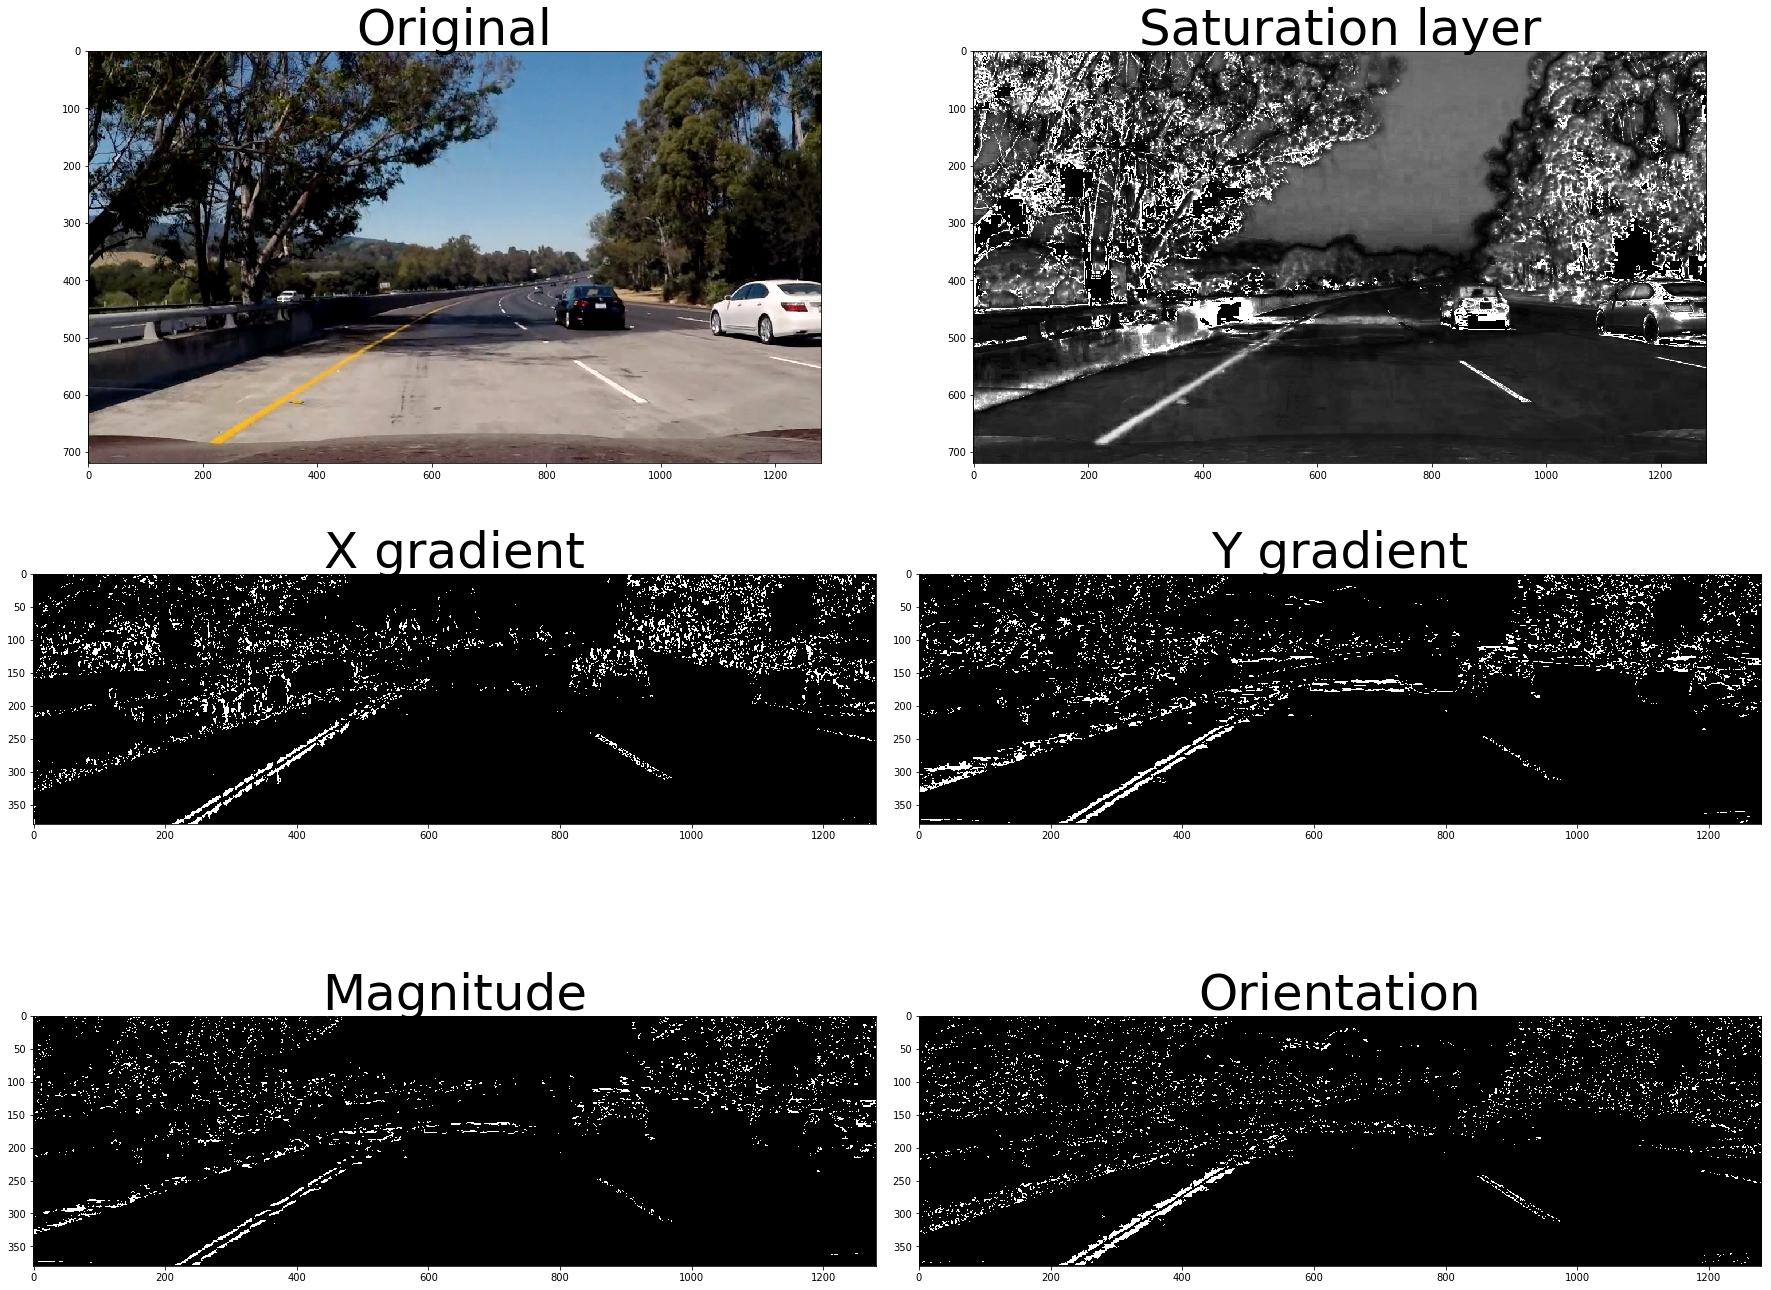

In [101]:
# Gradient thresholding function

# Accepts a RGB image as input, and generate several bitmasks with the same dimensions as output.
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def gradient_thresh(image, tasks=['x','y','mag','angle'], thresh=[(0, 255)]*4, sobel_kernel=9, minmag=10):
    """
    The unique function computes the gradient components alongside x and y directions, and
    outputs the requested masks obtained by the application of the specified thresholds to the gradient based 
    quantities.
    image is a single channel 2D image (channel 0 of color images is used: usually it will be the red channel)
    tasks is a list of tags, by default all available tags are returned.
    thresh is a list of tuples giving the min and max thresholds corresponding to each tag, in the same order.
    sobel_kernel is the size of the kernel used to compute the gradient (n x n). 
    minmag is a minimum magnitude applied as an additional condition to the angle task.
    Returns the binary masks in the same order as they appear in tasks. None is returned when unsupported 
    
    """
    assert len(thresh) >= len(tasks), 'gradient_thresh: supply one threshold tuple per requested task.'
    # Apply the following steps to img
    # 1) Select channel
    if len(image.shape) == 3:
        assert image.shape[2] <= 3 , 'gradient_thresh: more than 3 channels ? Check that channel order is [height,width,color].'
        gray = image[:,:,0]
        print('gradient_thresh')
    else:
        assert len(image.shape) == 2, 'gradient_thresh: image input must be 2D numpy image'
        gray = image
        
    # 2) Take the derivative in x and y (one or both can be optimised out according to requested tasks)
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if ('x' in tasks) or ('mag' in tasks) or ('angle' in tasks):
        derx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
        abs_derx = np.abs(derx)
    if ('y' in tasks) or ('mag' in tasks) or ('angle' in tasks):
        dery = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
        abs_dery = np.abs(dery)
        
    # Generate outputs
    masks = [None]*len(tasks)
    
    if 'x' in tasks:
        # 5x) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
        index = tasks.index('x')
        thresholds = thresh[index]
        # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled = np.uint8(np.floor(abs_derx*(255.99 / np.max(abs_derx))))
        masks[index] = color_thresh(scaled, thresholds)
    
    if 'y' in tasks:
        # 5y) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
        index = tasks.index('y')
        thresholds = thresh[index]
        # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled = np.uint8(np.floor(abs_dery*(255.99 / np.max(abs_dery))))
        masks[index] = color_thresh(scaled, thresholds)
    
    if ('mag' in tasks) or ('angle' in tasks):
        # 5) Calculate the magnitude (also used by 'angle' below)
        grad = np.sqrt(abs_derx * abs_derx + abs_dery * abs_dery)
        # 6) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_grad = np.uint8(np.floor(grad*(255.99/np.max(grad))))
        if 'mag' in tasks:
            # 6mag) Extract thresholds from thresh list
            index = tasks.index('mag')
            thresholds = thresh[index]
            masks[index] = color_thresh(scaled, thresholds)
    
    if 'angle' in tasks:
        # 5angle) Extract thresholds from thresh list
        index = tasks.index('angle')
        thresholds = thresh[index]
        # 6) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
        angle = np.arctan2(abs_dery, abs_derx)
        # Arctan2 returns value between 0 and np.pi/2 which are scaled to [0,255]
        scaled = np.uint8(np.floor(angle*(255.99/(np.pi/2))))
        binary = color_thresh(scaled, thresholds)
        # Apply additional magnitude criterion
        binary[(scaled_grad < minmag)] = 0
        masks[index] = binary
       
    # Return output masks
    return masks

# Demonstration of the above function
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

# Apply function                          
(xmask, ymask, magmask, anglemask) = gradient_thresh(hls[300:680,:,2], 
                                                     thresh=[(10,120),(15,140),(24,160),(100,240)])

%matplotlib inline

# Clean masks
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)

# Display images
f, ((ax0,axh), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(24, 20))
f.tight_layout()

ax0.imshow(img)           
ax0.set_title('Original', fontsize=50)
axh.imshow(hls[:,:,2], cmap='gray')
axh.set_title('Saturation layer', fontsize=50)
ax1.imshow(cv2.erode(xmask,kernel), cmap='gray')
ax1.set_title('X gradient', fontsize=50)
ax2.imshow(cv2.erode(ymask,kernel), cmap='gray')
ax2.set_title('Y gradient', fontsize=50)
ax3.imshow(cv2.erode(magmask,kernel), cmap='gray')
#ax3.imshow(magmask, cmap='gray')
ax3.set_title('Magnitude', fontsize=50)
ax4.imshow(cv2.erode(anglemask,kernel), cmap='gray')
ax4.set_title('Orientation', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Clean up workspace
del ax0, axh, ax1, ax2, ax3, ax4, f, hls, img, xmask, ymask, magmask, anglemask, kernel

In order to implement robust line detection, we will combine multiple detection methods based on gradients and value thresholds. However, gradients detect the edge of flat colored areas, so we have here a function which fills gradient images using an add/even algorithm line by line.

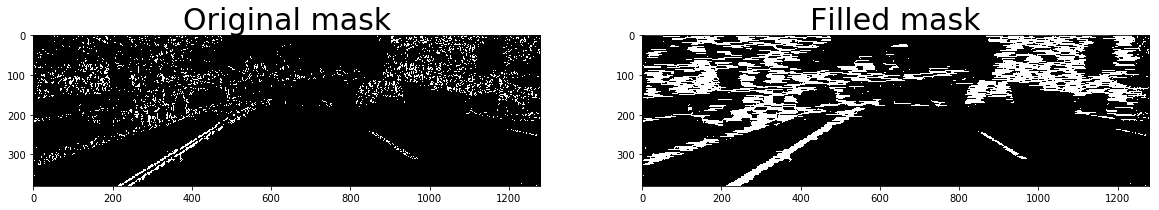

In [130]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def fill_gradient(img, max_line_width=50):
    """
    Accepts a gradient binary image, and fills the pixels between two input pixels situated on the same line, if 
    and only if the distance between them is acceptable for a lane line.
    """
    out = np.copy(img)
    for line in out:
        x = 0
        count = 0
        pixel = 1
        while x < out.shape[1] - max_line_width:
            if count == max_line_width - 1:
                pass
            elif line[x] != 0:
                if count == 0: pixel = line[x]
                # Increment counter of contiguous white pixels
                count += 1
            elif count > 0:
                window = line[x:x+max_line_width-count]
                match = np.argmax(window[::-1])
                if match > 0:
                    match = max_line_width-count-match
                    window[:match-1] = pixel
                    x += match
                count = 0
            x += 1 
    return out

# Demonstration of the above function
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)

# Apply function                          
(xmask,) = gradient_thresh(hls[300:680,:,2], tasks=['x'], thresh=[(10,120)])

# Clean and fill gradient mask
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)
xmask = cv2.erode(xmask, kernel)
xfilled = fill_gradient(xmask)

%matplotlib inline

# Visualize masks
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(xmask, cmap='gray')
ax1.set_title('Original mask', fontsize=30)
ax2.imshow(xfilled, cmap='gray')
ax2.set_title('Filled mask', fontsize=30)

# Clean up workspace
del ax1, ax2, f, kernel, xmask, img, hls, xfilled

We now have all the tools to implement a majority voting system which will extract the lane lines. Confidence is iteratively estimated by comparison of the solution with each image source.

The various masks are merely summed, and the resulting image is thresholded, in order to implement the majority voting. If the iterate parameter is true, the weights of each input mask are automatically varied to reduce the weight of the masks which are farther away from the voted solution. The number of iterations is bounded.

All the lane lines are extracted first, then a yellow line mask is used to tag yellow line pixels.

(380, 1280)


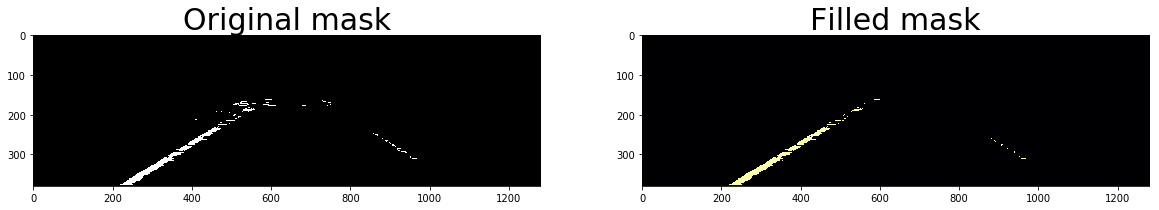

In [134]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Global constant
# Default image mask
DEFAULT_MASK = mpimg.imread('output_images/straight_mask.png')   # binary PNG
DEFAULT_THRESHOLDS = [(10,120),(15,140),(24,160),(100,240)]

def extract_lane_lines(img, mask=None, yellow=False, iterate=False, thresh=None, stripe = range(300,680)):
    """
    Returns one (two if yellow=True) binary images containing mostly pixels belonging to the lane lines, which
    are detected using multiple criteria on the input image.
    img: a RGB encoded image.
    mask: an optional mask with ones in the areas where lane lines can be. It is used to eliminate noise
        in the input image, and also to select pixels which are counted in the vote.
        Defaults to global constant DEFAULT_MASK, which is a binary numpy array.
    yellow: whether to apply yellow line detection. A second bitmap is output when yellow is true. Defaults to False.
    iterate: controls whether vote is refined by giving weights to vote inputs.
    thresh: an optional list of four pairs of integers between 0 and 255 giving thresholds for 
            x gradient, y gradient, gradient magnitude and gradient orientation as in gradient_thresh.
            Default to global constant DEFAULT_THRESHOLDS.
    stripe: a range of lines to consider in img. Defaults to range(300,680).
    """
    if mask is None:
        mask = DEFAULT_MASK[:,:,0].reshape(DEFAULT_MASK.shape[:2])
    assert mask.shape == img.shape[:2], 'extract_lane_lines: mask and img dimensions differ.'
    mask = mask[stripe]
    
    if thresh is None:
        thresh = DEFAULT_THRESHOLDS
    assert len(thresh)==4, 'extract_lane_lines: thresh must be a list of four pairs of uint8 numbers.'
    
    # 1) Convert region of interest to HLS color space
    hls = cv2.cvtColor(img[stripe],cv2.COLOR_RGB2HLS)
    # 2) Extract all the gradients
    (xmask, ymask, magmask, anglemask) = gradient_thresh(hls[:,:,2], thresh=thresh)
    # 3) Clean up and fill gradients
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)
    xmask = fill_gradient(cv2.erode(xmask,kernel))
    ymask = fill_gradient(cv2.erode(ymask,kernel))
    magmask = fill_gradient(cv2.erode(magmask,kernel))
    anglemask = fill_gradient(cv2.erode(anglemask,kernel))
    # 4) Extract colors
    huemask = color_thresh(hls[:,:,0],(15,100))
    satmask = color_thresh(hls[:,:,2],(192,255))
    
    # 6) Iterative vote
    # Stack inputs
    inputs = np.stack([xmask,ymask,magmask,anglemask,satmask], axis=2)
    nb_inputs = inputs.shape[2]
    # Initialize and normalize weights
    weights = np.ones(nb_inputs).reshape((nb_inputs,1)) / nb_inputs
    
    # Iterate maximum N times
    if iterate:
        iterate=5
    else:
        iterate=1
    
    binary = np.zeros_like(xmask)
    for i in range(iterate):
        votes = np.dot(inputs,weights).reshape(xmask.shape)
        binary[(votes>0.66) & (mask == 1)] = 1
        #TODO: confidence computation and weights update...
        
    # 7) Detect yellow lines
    if yellow:
        yellow_out = np.copy(binary)
        yellow_out[(huemask==0)] = 0   # turn off non-yellow lines
        return binary, yellow_out
    
    return binary

# Demonstration
img = mpimg.imread('test_images/test5.jpg')    # Read to RGB pixel format 

#print(img.shape, DEFAULT_MASK.shape)
lanes, yellow = extract_lane_lines(img, yellow=True)

# Visualize masks
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(lanes, cmap='gray')
ax1.set_title('Original mask', fontsize=30)
ax2.imshow(yellow, cmap='inferno')
ax2.set_title('Filled mask', fontsize=30)

